In [2]:
from pyiron import Project
import numpy as np 
import matplotlib.pyplot as plt

from itertools import combinations, permutations

%config inlinebackend.figure_format='retina'

In [3]:
pr = Project('pr/Chemical_potential')
pr_Mg = Project('pr_Mg/Murn')
pr_Ga = Project('pr_Ga/Structure')
pr_0 = Project('pr_0/Sigma7_A_T_VASP_ISIF_3')

In [4]:
# class to plot DPDs
class plot_DPD():
    
    def __init__(self, mu_x, energies, labels, colors):
        self.mu_x = mu_x
        self.energies = energies
        self.labels = labels
        self.colors = colors
        self.indices = []

    def ret_mu_pos(self, x, y): # function to return intersection point of 2 formation energy lines
        '''
        Returns intersection point of 2 formation energy lines
        '''
        for i, s in enumerate(y):
            if s<x[i]:
                ind = i
                break
            else:
                ind = len(x)
        return ind
    
    def get_indices(self):
        '''
        Returns list containing starting index, intersection indices and ending index; list containing indices of energies stable in DPD and list containing indices of energies not stable in DPD.
        '''    
        inds_selected, inds_rejected, final_inds = [], [], [0]
        counter = 0
        for i in range(len(self.energies)-1): 
            if counter != 0:
                counter -= 1
                inds_rejected.append(i)
                continue
            else:
                ind = []
                for j in range(i+1,len(self.energies)):
                    ind.append(self.ret_mu_pos(self.energies[i], self.energies[j]))

                k = np.where(ind==np.min(ind))[0][0]
                if k == 0:
                    inds_selected.append(i)
                    final_inds.append(self.ret_mu_pos(self.energies[i], self.energies[i+1]))

                else: # skip to next lowest energy level 
                    counter = k
                    inds_selected.append(i)
                    final_inds.append(self.ret_mu_pos(self.energies[i], self.energies[i+k+1]))
                    
        final_inds.append(len(self.energies[0]))
                
        return final_inds, inds_selected, inds_rejected
    
    def plot(self, xlim=[-1, 0], ylim=[-5,25], xlabel=r'$\Delta\mu_{\rm Ga}$ [eV]', ylabel=r'$E_{\rm f}$ [meV/$\rm \AA^2$]', alpha_fill=1, legend=True):
        '''
        Plots the DPD for the given chemical potential and formation energies. 
        Args:
            xlim: x-axis limits; default is [-1,0]
            ylim: y-axis limits; default is [-5,25]
            xlabel: x-axis Label; default is "r'$\Delta\mu_{\rm Ga}$ [eV]'"
            ylabel: y-axis Label; default is "r'$E_{\rm f}$ [meV/$\rm \AA^2$]'"
            alpha_fill: alpha parameter to control transparency in shaded regions; default is 1.0
        '''
        final_inds, inds_selected, inds_rejected = self.get_indices()
        
        plt.figure(figsize=(8,5))
        plt.xlim(xlim[0], xlim[-1])
        plt.ylim(ylim[0], ylim[1])
        plt.xlabel(xlabel, fontsize=18)
        plt.ylabel(ylabel, fontsize=18, labelpad=-5)
        plt.tick_params(axis='both', direction='in', top=True, right=True, length=10, pad=8, labelsize=17)
        
        counter = 0
        k = 0
        for i in range(len(self.energies)):
            if len(inds_rejected)>0 and i != inds_rejected[counter]:
                plt.plot(self.mu_x[:final_inds[k]], 1000*self.energies[i][:final_inds[k]], c=self.colors[i], alpha=0.5, ls='--', lw=2)
                plt.plot(self.mu_x[final_inds[k+1]:], 1000*self.energies[i][final_inds[k+1]:], c=self.colors[i], alpha=0.3, ls='--', lw=2)
                plt.plot(self.mu_x[final_inds[k]:final_inds[k+1]], 1000*self.energies[i][final_inds[k]:final_inds[k+1]], c=self.colors[i], lw=2, label=self.labels[i])
                
                plt.fill_between(self.mu_x[final_inds[k]:final_inds[k+1]], 1000*self.energies[i][final_inds[k]:final_inds[k+1]], 
                                 y2=1000*np.min(self.energies), color=self.colors[i], alpha=alpha_fill)
                
                k += 1
            elif len(inds_rejected)==0:
                plt.plot(self.mu_x[:final_inds[k]], 1000*self.energies[i][:final_inds[k]], c=self.colors[i], alpha=0.5, ls='--', lw=2)
                plt.plot(self.mu_x[final_inds[k+1]:], 1000*self.energies[i][final_inds[k+1]:], c=self.colors[i], alpha=0.3, ls='--', lw=2)
                plt.plot(self.mu_x[final_inds[k]:final_inds[k+1]], 1000*self.energies[i][final_inds[k]:final_inds[k+1]], c=self.colors[i], lw=2, label=self.labels[i])
                
                plt.fill_between(self.mu_x[final_inds[k]:final_inds[k+1]], 1000*self.energies[i][final_inds[k]:final_inds[k+1]], 
                                 y2=1000*np.min(self.energies), color=self.colors[i], alpha=alpha_fill)
                
                k += 1

            else:
                plt.plot(self.mu_x, 1000*self.energies[i], c=colors[i], ls='--', lw=2, label=self.labels[i])
                if counter < len(inds_rejected)-1:
                    counter += 1
                    
        plt.tight_layout()
        if legend:
            plt.legend(fontsize=13)

In [5]:
job = pr_Mg.load('Mg_bulk')
mu_Mg = job.output.energy_tot[-1]/len(job.structure)

job = pr_Ga.load('Ga_bulk')
mu_Ga = job.output.energy_tot[-1]/len(job.structure)

In [6]:
mu_Mg, mu_Ga

(-1.5065073075, -2.9067873625)

In [7]:
structure = pr.create.structure.read('DPD_data/Sigma_7B_A_DFT_160.POSCAR')
structure_t = pr.create.structure.read('DPD_data/Sigma_7B_T_DFT_160.POSCAR')

s_atoms = [153,   151,  152, 156, 157,  1,   0,   2]
sites =   ['a1', 'a2', 'a3', 'b', 'c', 'd', 'e', 'f']

s_atoms_2 = [153,   151,  152, 156, 157,  1,   0,   2,   154,   155,   146,   145,   143]
sites_2 =   ['a1', 'a2', 'a3', 'b+', 'c+', 'd+', 'e+', 'f+', 'b-', 'c-', 'd-', 'e-', 'f-']

In [8]:
job = pr_0.load('sig7b_type_a_eps_final_160')
en_0Ga = job.output.energy_tot[-1]

job = pr_0.load('sig7b_type_t_eps_final_160')
en_0Ga_t = job.output.energy_tot[-1]

In [9]:
pr_tables = Project('pr_tables/S7_GB_tables')

all_labels, all_energies, min_inds = [], [], []
for i in range(1,7):
    tab = pr_tables.load(str('Ga{}Mg{}').format(i, 158-i))
    df = tab.get_dataframe()
    df = df[df['GB Type'] == 'A']
    labels = np.unique(df['GB Site Labels'].tolist())
    energies, labels_list = [], []
    for j in range(len(labels)):
        energies.append(np.min(df[df['GB Site Labels'] == labels[j]]['Energy'].tolist()))
        labels_list.append(str(labels[j]).replace('p','').replace('m','\''))
    all_labels.append(labels_list)
    all_energies.append(energies)
    min_inds.append(np.argmin(energies))

In [12]:
# Grain boundary Area
A_t = 2*structure.cell[2][2]*structure.cell[1][1]

In [13]:
# pure MG GB formation energies
Ef_0Ga_GB = (en_0Ga - (len(structure)*mu_Mg))/A_t # formation energy of pure A type GB
Ef_0Ga_GB_T = (en_0Ga_t - (len(structure_t)*mu_Mg))/A_t # formation energy of pure T type GB

In [14]:
start_mu = mu_Ga - 1
end_mu = mu_Ga + 0.5

def formation_energies(n, t, e_sup):
    Ef_initial = 2*e_sup - en_0Ga - (t-(2*n))*mu_Mg - (2*n)*(start_mu)
    Ef_final = 2*e_sup - en_0Ga - (t-2*n)*mu_Mg - 2*n*(end_mu)
    return np.linspace(Ef_initial, Ef_final, 1500)/A_t

In [15]:
formation_energies_list, labels_list = [], []
for i in range(1,7):
    formation_energies_list.append(formation_energies(i, len(structure), all_energies[i-1][min_inds[i-1]]))
    labels_list.append(all_labels[i-1][min_inds[i-1]])

In [16]:
# chemical potential of precipitate
pr_bulk = Project('pr_bulk/Murn/')
job = pr_bulk.load('Mg_bulk')
E_Mg_bulk_pure = (job.output.energy_tot[-1]/len(job.structure))

pr_mu = Project('pr_mu/Structure/')

job = pr_mu.load('Mg5Ga_relax')
print(len(job.structure))
E_Mg5Ga_relaxed = job.output.energy_tot[-1]
relaxed_struct = job.get_structure()

N_Mg = len(relaxed_struct.select_index(el='Mg'))
N_Ga = len(relaxed_struct.select_index(el='Ga'))

mu_Ga_Mg5Ga_relaxed = (E_Mg5Ga_relaxed - (N_Mg*E_Mg_bulk_pure))/N_Ga

job = pr_mu.load('Mg5Ga_constrained')
E_Mg5Ga_constd = job.output.energy_tot[-1]
constrained_struct = job.get_structure()

N_Mg = len(constrained_struct.select_index(el='Mg'))
N_Ga = len(constrained_struct.select_index(el='Ga'))

mu_Ga_Mg5Ga_constd = (E_Mg5Ga_constd - (N_Mg*E_Mg_bulk_pure))/N_Ga
mu_Ga_Mg5Ga_relaxed, mu_Ga_Mg5Ga_constd

28


(-3.35680607125, -2.7504468925)

In [17]:
pr_ga_bulk = Project('pr_ga_bulk/Bulk1Ga')

job = pr_ga_bulk.load('Mg_bulk_sig7_1Ga')
bulk_energy_Ga = job.output.energy_tot[-1]
bulk_Ga = job.structure

del_H_ss = bulk_energy_Ga - E_Mg_bulk_pure*(len(bulk_Ga)-1)

In [18]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

num = 20
mus = np.linspace(0, num, num+1, dtype=int)

colorparams = mus

colormap = cm.summer

normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

colors = []
num = 9
lim = 3
for i in range(lim):
    colors.append(colormap(normalize(mus[num+i*3])))
colors.reverse()


num = 20
mus = np.linspace(0, num, num+1, dtype=int)
colorparams = mus

colormap = cm.ocean

normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

colors.append(colormap(normalize(mus[int(len(mus)/1.34)])))

for i in range(lim):
    colors.append(colormap(normalize(mus[(12-i*3)%len(mus)])))
# colors.reverse()
    
text_col = 'k'

Text(-0.49, 2.5, '$\\mu_{\\rm Mg_5Ga_2}$')

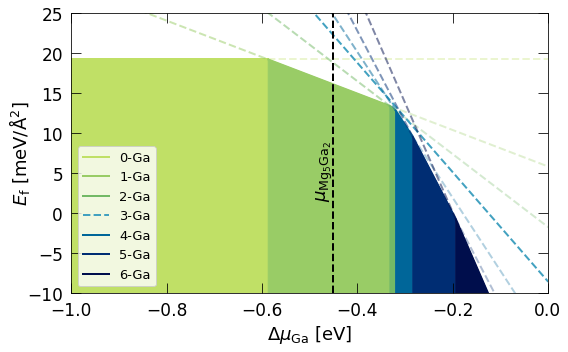

In [19]:
final_mu_Ga = np.linspace(mu_Ga-1, end_mu, 1500)
DPD = plot_DPD(mu_x=final_mu_Ga-mu_Ga, energies=np.concatenate([[np.array([Ef_0Ga_GB_T]*len(formation_energies_list[0]))], np.array(formation_energies_list)]), colors=colors, 
               labels=['0-Ga', '1-Ga', '2-Ga', '3-Ga', '4-Ga', '5-Ga', '6-Ga'])
DPD.plot(xlim=[-1,0], ylim=[-10,25], alpha_fill=1, legend=True)

plt.axvline(x=mu_Ga_Mg5Ga_relaxed-mu_Ga, ymax=2, ymin=0, color='k', ls='--', lw=2)
plt.text(s=r'$\mu_{\rm Mg_5Ga_2}$', x=-0.49, y=2.5, c='k', fontsize=18, rotation=90)

## Experimental DPD energies

In [20]:
def get_index(l, cond):
    for i in range(len(l)):
        if l[i] == cond:
            break
            
    if l[i] == cond:        
        return i
    else:
        print('Match not found')

In [21]:
ind_2 = get_index(all_labels[2], str("b_c\'_e\'"))

ind_6 = get_index(all_labels[-1], str('b_c_e_b\'_c\'_e\''))

In [22]:
Ef_3Ga_exp = formation_energies(3, len(structure), all_energies[2][ind_2])
Ef_6Ga_exp = formation_energies(6, len(structure), all_energies[-1][ind_6])

In [23]:
ind_1_b, ind_1_c, ind_1_e = get_index(all_labels[0], str("b")), get_index(all_labels[0], str("c")), get_index(all_labels[0], str("e"))

In [24]:
E_1Ga_b = formation_energies(1, len(structure), all_energies[0][ind_1_b])

# E_1Ga_c = formation_energies(1, len(structure), all_energies[0][ind_1_c])

# E_1Ga_e = formation_energies(1, len(structure), all_energies[0][ind_1_e])

## Experimental DPD

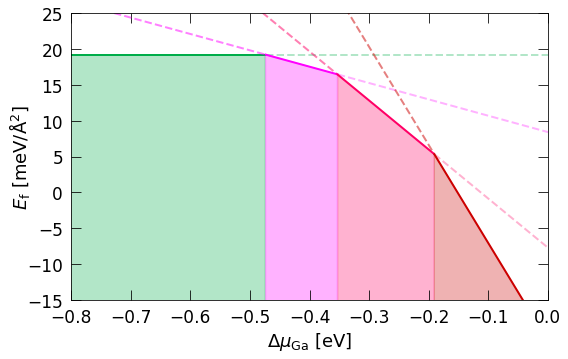

In [25]:
final_mu_Ga = np.linspace(mu_Ga-1, end_mu, 1500)
exp_colors = ['#00ad4a', '#ff00ff', '#ff0066', '#cc0000']
text_col = 'white'

DPD = plot_DPD(mu_x=final_mu_Ga-mu_Ga, energies=np.array([[Ef_0Ga_GB_T]*len(E_1Ga_b), E_1Ga_b, Ef_3Ga_exp, Ef_6Ga_exp]), colors=exp_colors, 
               labels=['0-Ga', '1-Ga', '3-Ga', '6-Ga'])

DPD.plot(xlim=[-0.8,0], ylim=[-15,25], alpha_fill=0.3, legend=False)